1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech


2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?



In [1]:
import warnings

import numpy as np
import pandas as pd

from string import punctuation
from stop_words import get_stop_words

import re

from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Настройки проекта

In [2]:
# Отключение предупреждений.
warnings.filterwarnings('ignore') 

# Путь к данным.
PATH_DATA = 'C:/Ангелина/Data Sience/4 четверть/PyTorch/6/train.csv'

# Случайное зерно.
GLOBAL__RANDOM_STATE = 0


# Настройки обработки текста.

# MAX_WORDS = 2000
MAX_WORDS = 3000

# MAX_LEN = 20
MAX_LEN = 30

NUM_CLASSES = 1

#### Подготовка данных

In [3]:
# Загрузка данных.
df = pd.read_csv(PATH_DATA, index_col='id')

In [4]:
# Проверка: вывод вервых пяти строк.
df.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


In [5]:
# Вывод размерности датасета.
df.shape

(31962, 2)

In [6]:
# Инициализация инструмента лемматизации.
lemmatizer = WordNetLemmatizer()

In [7]:
# Проверка: лемматизация слов.
print(
    f"cars\t->\t{lemmatizer.lemmatize('cars')}" \
    f"\ngoes\t->\t{lemmatizer.lemmatize('goes')}"
)

cars	->	car
goes	->	go


In [8]:
# Функция для подготовки текста:
def text_preprocessing(text):
    # удаление никнеймов,
    text = text.replace('@user ', '')
    
    # удаление прочих небуквенных и числовых символов,
    for symbol in punctuation:
        text = text.replace(symbol, '')
    
    # приведение текста к нижнему регистру,
    text = text.lower()
    
    # лемматизация слов в тексте,
    text = [*map(lemmatizer.lemmatize, text.split())]
    
    # исключение некорректных слов и стоп-слов,
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in get_stop_words(language='en')]
    
    # соединение массива в строку.
    text = " ".join(text)
    
    return text

In [9]:
%%time


# Предобработка твитов.
df['tweet_preprocessed'] = df['tweet'].apply(lambda text: text_preprocessing(text))

Wall time: 2.85 s


In [10]:
# Проверка: вывод вервых пяти строк.
df.head()

,label,tweet,tweet_preprocessed
id,,,
1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause dont offer w...
3,0,bihday your majesty,bihday majesty
4,0,#model i love u take with u all the time in ...,model love u take u time
5,0,factsguide: society now #motivation,factsguide society now motivation


In [11]:
# Загрузка всех слов из твитов.
words = " ".join(df['tweet_preprocessed'])
words = words.split()

In [12]:
# Проверка: вывод первых десяти слов и общего количества слов.
words[:10], len(words)

(['father',
  'dysfunctional',
  'selfish',
  'drag',
  'kid',
  'dysfunction',
  'run',
  'thanks',
  'lyft',
  'credit'],
 253334)

In [13]:
# Определение частоты каждого слова.
top_words = FreqDist(words)

In [14]:
# Проверка: вывод наиболее частых слов и количества уникальных слов во всех твитах.
top_words, len(top_words)

(FreqDist({'love': 2695, 'day': 2679, 'happy': 1662, 'u': 1645, 'amp': 1582, 'just': 1346, 'will': 1271, 'time': 1219, 'life': 1189, 'im': 1139, ...}),
 37683)

In [15]:
# Формирование словаря наиболее частых слов.
dict_top_words = dict((pair[0], pair[1]) for pair in top_words.most_common(MAX_WORDS - 1))

In [16]:
# Вывод первых шести наиболее частых слов и количества их вхождений в текст.
i = 0

for word, frequency in dict_top_words.items():
    i += 1
    print(word, frequency)
    if i > 5:
        break

love 2695
day 2679
happy 1662
u 1645
amp 1582
just 1346


In [17]:
# Формирование словаря индексов наиболее частых слов.
dict_top_words = dict((word, index) for index, word in enumerate(dict_top_words.keys(), start=1))

In [18]:
# Вывод первых шести наиболее частых слов и их индексов.
i = 0

for word, index in dict_top_words.items():
    i += 1
    print(word, index)
    if i > 5:
        break

love 1
day 2
happy 3
u 4
amp 5
just 6


In [19]:
# Формирование списка наиболее частых слов.
list_top_words = [*dict_top_words.keys()]

In [20]:
# Проверка: вывод длины словаря и списка.
len(dict_top_words), len(list_top_words)

(2999, 2999)

In [21]:
# Функция для преобразования текста в числовую последовательность:
def text_to_sequence(text, maxlen=MAX_LEN):
    # разбиение строки на массив,
    text = text.split()
    
    # фильтрация, останутся только индексы наиболее частых слов,
    text = [dict_top_words[word] for word in text if word in list_top_words]
    
    # выбор первых MAX_LEN слов,
    text = text[:MAX_LEN]
    
    # дополнение нулями, если не набралось 20 слов.
    text = text + [0] * (MAX_LEN - len(text))
    
    return text

In [22]:
# Твиты до токенизации.
df['tweet_preprocessed'].head()

id
1    father dysfunctional selfish drag kid dysfunct...
2    thanks lyft credit cant use cause dont offer w...
3                                       bihday majesty
4                             model love u take u time
5                    factsguide society now motivation
Name: tweet_preprocessed, dtype: object

In [23]:
# Твиты после токенизации.
df['tweet_preprocessed'].head().apply(lambda x: text_to_sequence(x))

id
1    [19, 2973, 129, 338, 0, 0, 0, 0, 0, 0, 0, 0, 0...
2    [106, 2153, 25, 342, 497, 30, 1051, 0, 0, 0, 0...
3    [24, 2974, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4    [83, 1, 4, 33, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0...
5    [2562, 1222, 15, 215, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: tweet_preprocessed, dtype: object

In [24]:
# Вывод токенов первого объекта.
df['tweet_preprocessed'].head().apply(lambda x: text_to_sequence(x))[1]

[19,
 2973,
 129,
 338,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [25]:
# Вывод длины токенов первого объекта.
len(df['tweet_preprocessed'].head().apply(lambda x: text_to_sequence(x))[1])

30

In [26]:
%%time


# Токенизация всех твитов.
df['tweet_tokenized'] = df['tweet_preprocessed'].apply(lambda x: text_to_sequence(x))

Wall time: 4.38 s


In [27]:
# Проверка: вывод вервых пяти строк.
df.head()

,label,tweet,tweet_preprocessed,tweet_tokenized
id,,,,
1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...,"[19, 2973, 129, 338, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause dont offer w...,"[106, 2153, 25, 342, 497, 30, 1051, 0, 0, 0, 0..."
3,0,bihday your majesty,bihday majesty,"[24, 2974, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,#model i love u take with u all the time in ...,model love u take u time,"[83, 1, 4, 33, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5,0,factsguide: society now #motivation,factsguide society now motivation,"[2562, 1222, 15, 215, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [28]:
# Класс датасета.
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [29]:
# Разбиение данных на обучающую и тестовую выборки.
df_train, df_test = train_test_split(df, test_size=0.25, random_state=GLOBAL__RANDOM_STATE, stratify=df['label'])

# Проверка: вывод размерностей.
df_train.shape, df_test.shape

((23971, 4), (7991, 4))

In [30]:
# Формирование обучающих датасета и загрузчика.
train_dataset = DataWrapper(np.array([*df_train['tweet_tokenized'].values]), df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Формирование тестовых датасета и загрузчика.
val_dataset = DataWrapper(np.array([*df_test['tweet_tokenized'].values]), df_test['label'].values)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [31]:
# Проверка обучающего загрузчика.
for x, y in train_loader:
    print(f'Размерность тензора объекта:\t{x[0].shape}')
    print(f'Тензор:\n\t{x[0]}')
    print(f'\nРазмерность тензора ответов в батче:\t{y.shape}')
    print(f'Первый ответ в батче:\t{y[0]}')
    break

Размерность тензора объекта:	torch.Size([30])
Тензор:
	tensor([  46,  211, 2839,  897,  284,   89,    2,  829,   74,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])

Размерность тензора ответов в батче:	torch.Size([512])
Первый ответ в батче:	0


#### Построение модели LSTM

In [32]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        self.ht = 0
        
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
#         lstm_out, self.ht = self.lstm(x, self.ht)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [33]:
# Инициализация модели.
# model = Net(vocab_size=MAX_WORDS)
model = LSTMFixedLen(MAX_WORDS, 128, 20, use_last=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [34]:
# Вывод структуры и количества обучаемых параметров модели.
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(3000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 399381


In [35]:
# Оптимизатор и функция потерь.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [36]:
%%time


# Обучение и валидация модели на десяти эпохах.
epochs = 10

model = model.to(device)
model.train()
th = 0.5

# Массивы для хранения значений функций потерь.
train_loss_history = []
test_loss_history = []

# Массивы для хранения значений метрики F1-score.
train_f1_history = []
test_f1_history = []

for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        
    # выводим статистику о процессе обучения
    model.eval()
    
    # Вычисление метрики на обучающей выборке.
    f1_train = f1_score(labels.numpy(), pred_labels.numpy(), average='macro', zero_division=0)
    train_f1_history.append(f1_train)
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}. ' \
            f'F1: {f1_train:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    # Вычисление метрики на тестовой выборке.
    f1_test = f1_score(test_labels.numpy(), pred_test_labels.numpy(), average='macro', zero_division=0)
    test_f1_history.append(f1_test)
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}. Test F1: {f1_test:.3f}.')
    print(classification_report(test_labels.numpy(), pred_test_labels.numpy()))
    
    model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [47/47]. Loss: 0.378. Acc: 0.920. F1: 0.483. Test loss: 0.298. Test acc: 0.930. Test F1: 1.000.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

Epoch [2/10]. Step [47/47]. Loss: 0.215. Acc: 0.930. F1: 0.486. Test loss: 0.438. Test acc: 0.930. Test F1: 0.462.
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.00      0.00      0.00         1

    accuracy                           0.86         7
   macro avg       0.43      0.50      0.46         7
weighted avg       0.73      0.86      0.79         7

Epoch [3/10]. Step [47/47]. Loss: 0.247. Acc: 0.930. F1: 0.481. Test loss: 0.064. Test acc: 0.930. Test F1: 1.000.
              precision    recall  f1-score   support



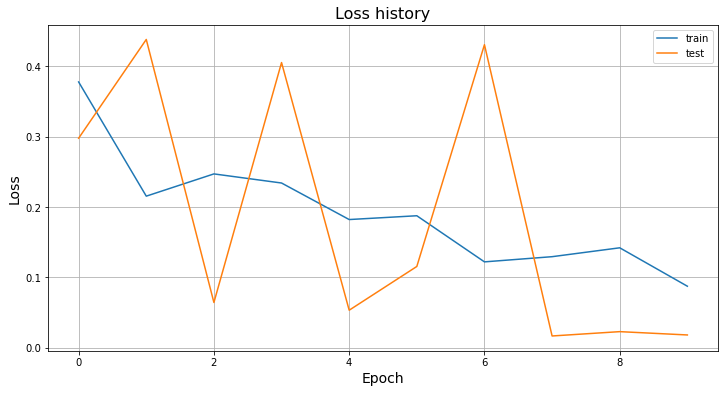

In [37]:
# Визуализация функций потерь на обучающей и тестовой выборках.
plt.figure(figsize=(12, 6))
plt.title('Loss history', fontdict={'size': 16})
plt.grid(True)
plt.ylabel('Loss', fontdict={'size': 14})
plt.xlabel('Epoch', fontdict={'size': 14})
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

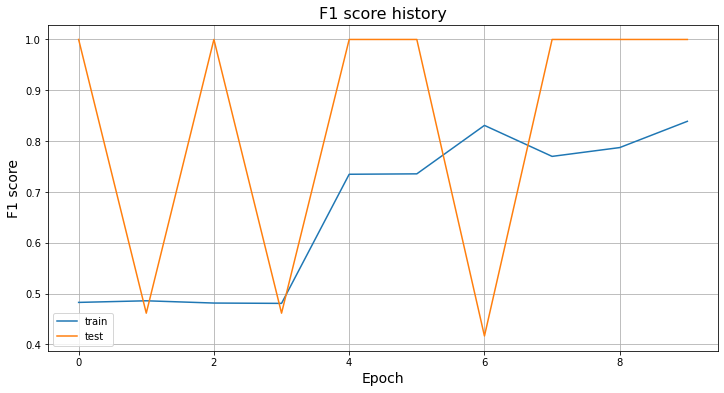

In [38]:
# Визуализация метрики качества на обучающей и тестовой выборках.
plt.figure(figsize=(12, 6))
plt.title('F1 score history', fontdict={'size': 16})
plt.grid(True)
plt.ylabel('F1 score', fontdict={'size': 14})
plt.xlabel('Epoch', fontdict={'size': 14})
plt.plot(train_f1_history, label='train')
plt.plot(test_f1_history, label='test')
plt.legend();

In [39]:
# Вывод информации о балансе классов.
df[['label']].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')

label
0        92.99%
1         7.01%
dtype: object

#### Построение модели GRU

In [50]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        self.ht = 0
        
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
#         lstm_out, self.ht = self.lstm(x, self.ht)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [51]:
# Инициализация модели.
# model = Net(vocab_size=MAX_WORDS)
model = GRUFixedLen(MAX_WORDS, 128, 20, use_last=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [52]:
# Вывод структуры и количества обучаемых параметров модели.
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(3000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 395541


In [53]:
# Оптимизатор и функция потерь.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [54]:
%%time


# Обучение и валидация модели на десяти эпохах.
epochs = 10

model = model.to(device)
model.train()
th = 0.5

# Массивы для хранения значений функций потерь.
train_loss_history = []
test_loss_history = []

# Массивы для хранения значений метрики F1-score.
train_f1_history = []
test_f1_history = []

for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        
    # выводим статистику о процессе обучения
    model.eval()
    
    # Вычисление метрики на обучающей выборке.
    f1_train = f1_score(labels.numpy(), pred_labels.numpy(), average='macro', zero_division=0)
    train_f1_history.append(f1_train)
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}. ' \
            f'F1: {f1_train:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    # Вычисление метрики на тестовой выборке.
    f1_test = f1_score(test_labels.numpy(), pred_test_labels.numpy(), average='macro', zero_division=0)
    test_f1_history.append(f1_test)
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}. Test F1: {f1_test:.3f}.')
    print(classification_report(test_labels.numpy(), pred_test_labels.numpy()))
    
    model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [47/47]. Loss: 0.249. Acc: 0.915. F1: 0.485. Test loss: 0.641. Test acc: 0.930. Test F1: 0.417.
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.00      0.00      0.00         2

    accuracy                           0.71         7
   macro avg       0.36      0.50      0.42         7
weighted avg       0.51      0.71      0.60         7

Epoch [2/10]. Step [47/47]. Loss: 0.234. Acc: 0.930. F1: 0.483. Test loss: 0.418. Test acc: 0.930. Test F1: 0.462.
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.00      0.00      0.00         1

    accuracy                           0.86         7
   macro avg       0.43      0.50      0.46         7
weighted avg       0.73      0.86      0.79         7

Epoch [3/10]. Step [47/47]. Loss: 0.274. Acc: 0.930. F1: 0.476. Test loss: 0.069. Test acc: 0.930. Test F1: 1.000.
 

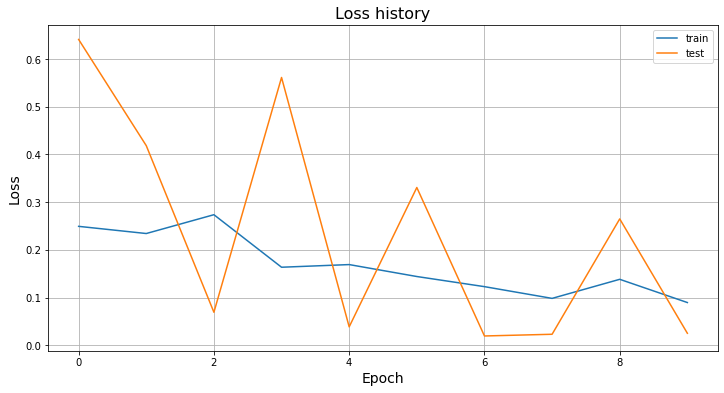

In [55]:
# Визуализация функций потерь на обучающей и тестовой выборках.
plt.figure(figsize=(12, 6))
plt.title('Loss history', fontdict={'size': 16})
plt.grid(True)
plt.ylabel('Loss', fontdict={'size': 14})
plt.xlabel('Epoch', fontdict={'size': 14})
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

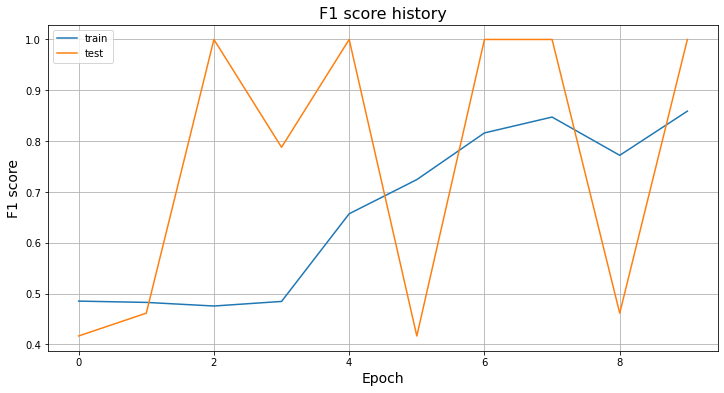

In [56]:
# Визуализация метрики качества на обучающей и тестовой выборках.
plt.figure(figsize=(12, 6))
plt.title('F1 score history', fontdict={'size': 16})
plt.grid(True)
plt.ylabel('F1 score', fontdict={'size': 14})
plt.xlabel('Epoch', fontdict={'size': 14})
plt.plot(train_f1_history, label='train')
plt.plot(test_f1_history, label='test')
plt.legend();

In [57]:
# Вывод информации о балансе классов.
df[['label']].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')

label
0        92.99%
1         7.01%
dtype: object

Из-за значительного дисбаланса классов, модели плохо обучается и идентифицирует объекты наименьшего класса, как GRU, так и LSTM.

Увеличение количества наиболее частых слов и длины последовательности позволило незначительно улучшить качество прогноза модели на тестовой выборке.